# A Brief History of Tokens 
 - [Bitcoin (2009)](#Bitcoin) 
 - [Coin Age (2011 - 2012)](#Coin-Age)
 - [First Mainstream Push (2013 - 2014)](#First-Mainstream-Push)
 - [First Recession (2014 - 2015)](#First-Recession)
 - [First Recovery (2016)](#First-Recovery)
 - [Second Mainstream Push (2017)](#Second-Mainstream-Push)
 - [Second Recession (2018 - 2019)](#Second-Recession)
 - [Second Recovery (2020)](#Second-Recovery)
 - [Third Wave (2021- ?)](#Third-Wave)

Todo:
- [Select the most salient tokens over time, constraining our sample set to those that have entered and remained in the top 5 for some period of time]([#Select-Tokens) 
- [Once these tokens are selected we get their market data, backfilling from crypto compare where coinmarketcap data is lacking](#Backfill)
- For each project let’s look at the motivation, alterations, development cycle and adoption (how are the ideas of the time realized or challenged by the given implementation) 
    - [NLP of whitepapers](#Whitepapers)
        - extract phrases/concepts and verify their originality (originality score?), cross referencing them with historical web search 
    - [Github, forum activity](#Github)
        - Contributor count 
    - [Rank from start to peak, time at peak](#Ranking) 
    - [Reddit](#Reddit)
        - News
        - Tech
        - Finance 
- [How have price spike provided a demarcation of ideas and concepts](#Prices)

In [4]:
from bs4 import BeautifulSoup
from ipywidgets import interact
from pandas.io.json import json_normalize
import os 
import time
import requests
from datetime import datetime as dt, timedelta as td
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={"figure.figsize": (20, 10)})

In [5]:
DATA_DIR = 'tmp'

In [6]:
def get_historical_rankings(date):
    url = 'https://coinmarketcap.com/historical/{}'.format(date.strftime('%Y%m%d'))
    response = requests.get(url).text
    soup = BeautifulSoup(response)
    table_head = soup.select('thead')[0]
    table_body = soup.select('tbody')[0]
    table_cols = [col.text for col in table_head.find_all('th')]
    table_data = [[data.text.strip() for data in row.find_all('td')] for row in table_body.find_all('tr')]
    rankings = pd.DataFrame(table_data, columns=table_cols)
    rankings['Date'] = date
    return rankings


def convert_str_to_float(v): 
    value = ''.join(c for c in v if c.isdigit() or c=='.')
    try:
        value = float(value)
    except Exception as e:
        value = 0
    return value


def normalize_cmc_data(cmc_raw_df):
    df = cmc_raw_df.copy()
    df['Ranking'] = rankings_df['#'].astype(int)
    df = df.rename(columns={
        'Circulating Supply':'Supply',
        'Market Cap':'Capitalization',
        'Volume (24h)': 'Volume'
    })
    df['Name'] = df.Name.apply(lambda n: n.split('\n\n')[1])
    for col in ['Supply','Price','Capitalization','Volume']:
        df[col] = df[col].apply(convert_str_to_float)
    
    df = df[
        [
            'Date',
            'Name',
            'Symbol',
            'Ranking',
            'Supply',
            'Price',
            'Capitalization',
            'Volume'
        ]
    ]
    
    return df.set_index(['Date','Symbol'])


In [47]:
# Fetch historical ranking data 

# check if directory and file already exist
csv_name = '{}/historical_rankings.csv'.format(DATA_DIR)
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

elif os.path.exists(csv_name):
    rankings_df = pd.read_csv(csv_name, parse_dates=['date'], infer_datetime_format=True)

else:
    start = dt(2013, 5, 1)
    end = dt(2019,2,1)
    rankings_df = pd.DataFrame()
    current_year = start.year
    for date in pd.DatetimeIndex(start=start, end=end, freq='1M'):
        if current_year < date.year:
            current_year = date.year
            print(current_year)
        rankings_df = rankings_df.append(get_historical_rankings(date), ignore_index=True)
    rankings_df = normalize_cmc_data(rankings_df)
    rankings_df.to_csv(csv_name)



2014
2015
2016
2017
2018
2019


In [72]:
df = rankings_df.reset_index()

In [109]:
df['Norm_Ranking'] = 1/df.Ranking
total_volume = df.groupby('Date').Volume.sum()
total_capitalization = df.groupby('Date').Capitalization.sum()
def get_pct_stats(d):
    pct_volume = d.Volume / total_volume.loc[d.Date]
    pct_cap = d.Capitalization / total_capitalization.loc[d.Date]
    return pct_volume, pct_cap
df['Pct_Volume'], df['Pct_Capitalization'] = zip(*df.apply(get_pct_stats, axis=1))


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


In [104]:
highest_ranked_tokens = rankings_df.groupby('Symbol').Ranking.mean().sort_values().head(50).index
grouped = df[df.Symbol.isin(highest_ranked_tokens)].groupby('Symbol')
#df[df.Symbol.isin((grouped.Norm_Ranking.mean()>.1).index)]
#grouped.Norm_Ranking.describe().sort_values('count', ascending=False)['75%']#.plot()
grouped.Norm_Ranking.describe()[grouped.Norm_Ranking.mean()>.05].sort_values('count', ascending=False)



,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
BTC,69.0,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
PPC,69.0,0.093176,0.088590,0.004785,0.012195,0.076923,0.142857,0.333333
LTC,69.0,0.305452,0.131782,0.125000,0.200000,0.250000,0.500000,0.500000
XRP,66.0,0.367424,0.092424,0.166667,0.333333,0.333333,0.500000,0.500000
NXT,62.0,0.080094,0.079283,0.008475,0.017295,0.059028,0.125000,0.333333
DOGE,62.0,0.103763,0.066248,0.018519,0.043478,0.080128,0.166667,0.250000
DASH,60.0,0.144459,0.061958,0.040000,0.089015,0.142857,0.175000,0.333333
MAID,58.0,0.082436,0.052656,0.009901,0.024585,0.095455,0.111111,0.200000
XMR,57.0,0.096227,0.040453,0.045455,0.071429,0.083333,0.100000,0.200000


In [133]:
col = 'Pct_Volume'

highest_ranked_tokens =df.groupby('Symbol')['Ranking'].mean().sort_values().head(50).index
grouped = df[df.Symbol.isin(highest_ranked_tokens)].groupby('Symbol')
#df[df.Symbol.isin((grouped[col].mean()>.1).index)]
#grouped[col].describe().sort_values('count', ascending=False)['75%']#.plot()
grouped[col].describe()[grouped[col].mean()>.02].sort_values('count', ascending=False)



,count,mean,std,min,25%,50%,75%,max
Symbol,,,,,,,,
BTC,62.0,0.598393,0.196197,0.271529,0.397392,0.641831,0.739864,0.911972
LTC,62.0,0.066225,0.058075,0.010900,0.024041,0.045127,0.091954,0.265055
XRP,62.0,0.026150,0.034039,0.000351,0.006297,0.016593,0.030045,0.193727
USDT,47.0,0.062049,0.082402,0.000000,0.004494,0.018965,0.123269,0.244006
ETH,42.0,0.129389,0.080219,0.009977,0.087786,0.115506,0.156052,0.352020
BCH,21.0,0.030194,0.022493,0.000000,0.014706,0.027181,0.041378,0.082133
EOS,19.0,0.039770,0.032395,0.003658,0.011891,0.041178,0.056157,0.132199


### Backfill

In [3]:
get_rankings = lambda symbol: 1/df[df.Symbol==symbol][['Ranking','Date']].set_index('Date')


def plot_feature_over_time(symbol, feature):
    s = df[df.Symbol == symbol][[feature,'Date']].set_index('Date')
    s.plot()
    s.hist()
    

interact(plot_feature_over_time, symbol=highest_ranked_tokens, feature=df.columns[3:])

NameError: name 'highest_ranked_tokens' is not defined

In [134]:
import cryptocompare

cryptocompare.get_historical_price_day

In [227]:

def cc_api(command, params):
    param_url_str = '&'.join(['{}={}'.format(k,v) for k, v in params.items()])
    url = 'https://min-api.cryptocompare.com/data/{}?{}'.format(command, param_url_str)
    res = requests.get(url).json()
    if 'Error' in res['Response']:
        print(res['Message'])
    elif 'Succes' in res['Response']:
        df = pd.DataFrame(res['Data'])#son_normalize(res['Data'])
        df.columns = [c.capitalize() for c in df.columns]
        return df


def get_historical_cc_data(command='histoday', fysm='BTC', tysm='USD', coinid=1182, 
                start=dt(2017,1,1), end=dt(2017,6,1), limit=100, aggregate=1, 
                api_key='3372391c6e1cf2a651761aebdb5f5b0462ba3ed6741ef8f479cb4a10b16adb64'):
    
    need_to_fetch = lambda df: len(df) == 0 or start < df.Time.min()
    to_unix_time = lambda dt: int(time.mktime(dt.timetuple()))

    df = pd.DataFrame()

    while need_to_fetch(df):

        temp_df = cc_api(command, {
            'fsym': fysm,
            'tsym': tysm,
            'limit': limit,
            'toTs': to_unix_time(end),
            'aggregate': aggregate,
            'coinId': coinid,
            'api_key': api_key
        })
        temp_df['Time'] = pd.to_datetime(temp_df.Time*1e9)
        end = temp_df.Time.min()
        df = pd.concat([df, temp_df[temp_df.Time>=start]]).sort_values('Time')
    
    print('DF Shape: {}'.format(df.shape))
    return df




In [246]:
coin_list = cc_api('all/coinlist', {}).T
coin_list['Symbol'] = coin_list.Symbol.str.upper()
coin_list = coin_list.set_index('Symbol')

In [250]:
coin_list[['CoinName', 'Id','Algorithm','BuiltOn','ImageUrl','Url']]#.loc['BTC']



,CoinName,Id,Algorithm,BuiltOn,ImageUrl,Url
Symbol,,,,,,
42,42 Coin,4321,Scrypt,N/A,/media/12318415/42.png,/coins/42/overview
300,300 token,749869,N/A,7605,/media/27010595/300.png,/coins/300/overview
365,365Coin,33639,X11,N/A,/media/352070/365.png,/coins/365/overview
404,404Coin,21227,Scrypt,N/A,/media/351001/404.png,/coins/404/overview
433,433 Token,926547,N/A,7605,/media/34836095/433.png,/coins/433/overview
611,SixEleven,20909,SHA256,N/A,/media/350985/611.png,/coins/611/overview
808,808,28223,SHA256,N/A,/media/351513/808.png,/coins/808/overview
888,Octocoin,29462,N/A,N/A,/media/351639/888.png,/coins/888/overview
1337,1337,20824,X13,N/A,/media/350976/1337.png,/coins/1337/overview


In [257]:
ts = get_historical_cc_data('social/coin/histo/day', start=dt(2010,1,1), end=dt.now(), limit=2000, coinid=coin_list.loc['BTS'].Id)

DF Shape: (3323, 33)


In [254]:
ts.columns.tolist()

['Analysis_page_views',
 'Charts_page_views',
 'Code_repo_closed_issues',
 'Code_repo_closed_pull_issues',
 'Code_repo_forks',
 'Code_repo_open_issues',
 'Code_repo_open_pull_issues',
 'Code_repo_stars',
 'Code_repo_subscribers',
 'Comments',
 'Fb_likes',
 'Fb_talking_about',
 'Followers',
 'Forum_page_views',
 'Influence_page_views',
 'Markets_page_views',
 'Overview_page_views',
 'Points',
 'Posts',
 'Reddit_active_users',
 'Reddit_comments_per_day',
 'Reddit_comments_per_hour',
 'Reddit_posts_per_day',
 'Reddit_posts_per_hour',
 'Reddit_subscribers',
 'Time',
 'Total_page_views',
 'Trades_page_views',
 'Twitter_favourites',
 'Twitter_followers',
 'Twitter_following',
 'Twitter_lists',
 'Twitter_statuses']

In [264]:
ts.describe().T

,count,mean,std,min,25%,50%,75%,max
Analysis_page_views,765.0,9445.849673,8149.828013,0.0,1076.0,8604.0,18906.00,20790.00
Charts_page_views,765.0,69098.133333,52206.594898,0.0,29907.0,69439.0,125502.00,141092.00
Code_repo_closed_issues,765.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
Code_repo_closed_pull_issues,765.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
Code_repo_forks,765.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
Code_repo_open_issues,765.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
Code_repo_open_pull_issues,765.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
Code_repo_stars,765.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
Code_repo_subscribers,765.0,0.000000,0.000000,0.0,0.0,0.0,0.00,0.00
Comments,765.0,1618.300654,1940.508028,0.0,183.0,897.0,2813.00,6715.00


DF Shape: (765, 33)


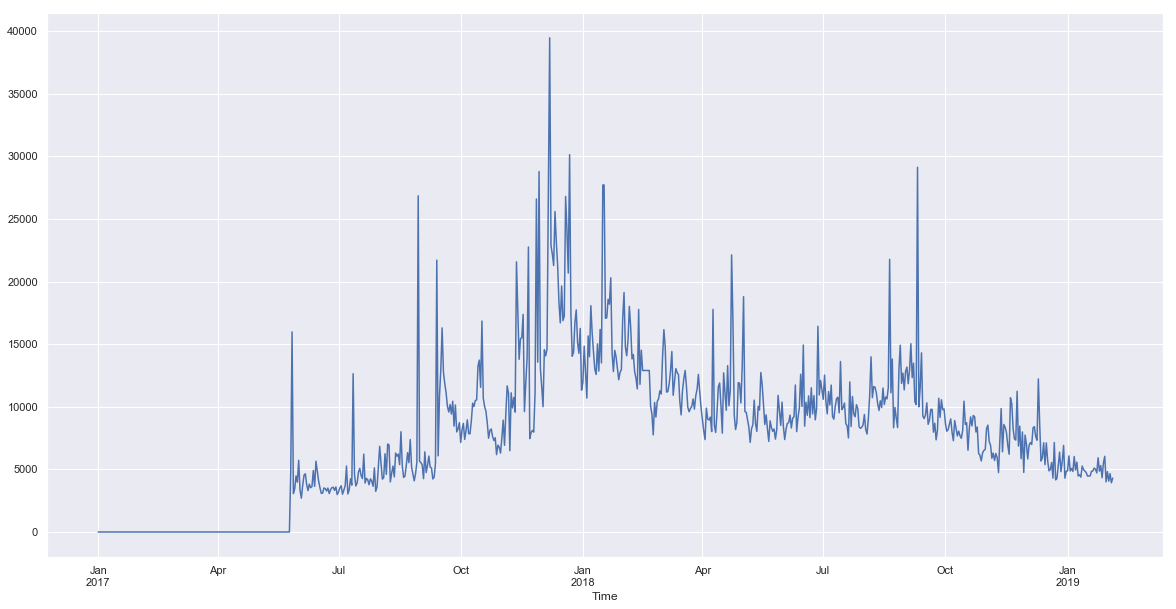

In [265]:
ts = get_historical_cc_data('social/coin/histo/day', start=dt(2017,1,1), end=dt.now(), limit=2000, coinid=coin_list.loc['BTC'].Id)
ts.set_index('Time').Reddit_active_users.plot()

#### Whitepapers

In [311]:
token_name = coin_list.loc['NXT'].CoinName
url = 'https://www.allcryptowhitepapers.com/{}-Whitepaper/'.format(token_name)
res = requests.get(url).text
soup = BeautifulSoup(res)




In [312]:
print(soup.select('.entry-content')[0].text.split('\n\n')[0])

In [277]:
soup

<!DOCTYPE html>
<html lang="en-US" prefix="og: http://ogp.me/ns#"><head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<link href="http://gmpg.org/xfn/11" rel="profile"/>
<link href="https://www.allcryptowhitepapers.com/xmlrpc.php" rel="pingback"/>
<title>BitShares Whitepaper</title>
<meta content="summary" name="twitter:card"/><meta content="The largest Crypto Whitepaper Database!" name="twitter:domain"/><meta content="Check out this Whitepaper and many more on: www.allcryptowhitepapers.com, the biggest database of Cryptocurrency and ICO whitepapers!" name="twitter:description"/><meta content="BitShares Whitepaper" name="twitter:title"/><meta content="The largest Crypto Whitepaper Database!" property="og:site_name"/><meta content="Check out this Whitepaper and many more on: www.allcryptowhitepapers.com, the biggest database of Cryptocurrency and ICO whitepapers!" property="og:description"/><meta content="https://www.allcryptowhitepapers.

## Bitcoin 

## Coin Age

## First Mainstream Push

## First Recession

## First Recovery

## Second Mainstream Push

## Second Recession

## Second Recovery

## Third Wave